# Control Module Test

First neighbor neighborhood of a control pathway network defines a module. Test each network for module enrichment.

In [1]:
import json
import networkx as nx
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

Import networks, BIONIC features, and control pathway network

In [77]:
# import BIONIC features
features = pd.read_csv("/ix/djishnu/Aaron_F/PGM_project/Bionic/eval/TLR4_Bionic_features.csv", index_col=0)

In [50]:
# read in TLR4_loopy_bp network
loopy_bp = pd.read_csv("/ix/djishnu/Aaron_F/PGM_project/Bionic/eval/TLR4_loopy_bp.csv", header=None)
# sparsify net
loopy_bp = loopy_bp.loc[loopy_bp[2]>=0.7,]
loopy_bp_net = nx.from_pandas_edgelist(loopy_bp, source=0, target=1)

In [57]:
# # read in coexp network
# coexp = pd.read_csv("/ix/djishnu/Aaron_F/PGM_project/Bionic/eval/20241114_decoded.coexp.forBIONIC.csv", header=None)
# # sparsify net
# coexp = coexp.loc[coexp[2]>=0.5,]
# coexp_net = nx.from_pandas_edgelist(coexp, source=0, target=1)

In [59]:
# read in ppi network
ppi = pd.read_csv("/ix/djishnu/Aaron_F/PGM_project/Bionic/eval/20241114_decoded.ppis.forBIONIC.txt.csv", header=None)
ppi_net = nx.from_pandas_edgelist(ppi, source=0, target=1)

Get the cluster from each network/features that matches the LSM2-7 complex.

In [16]:
# load TLR4 pathway network
pathway = pd.read_csv("/ix/djishnu/Aaron_F/PGM_project/TLR_pathway/Results/tlr_signaling_parsed_network_kegg_mmu04620.csv")

In [17]:
# pathway network
pathway_net = nx.from_pandas_edgelist(pathway, source="source", target="target")

In [90]:
# define module of interstest (moi) from pathway_net using first neighborhod of gene of interest (goi)
goi = "Mapk1"
moi = list(pathway_net.neighbors(goi))
moi+=[goi]

Transform the BIONIC features into a network.

In [78]:
# first compute pairwise cosine similarities between genes
features_sim = pd.DataFrame(
    cosine_similarity(features.values), index=features.index, columns=features.index
)

# sparsify the complete graph by removing edges below 0.5 similarity
features_sim[features_sim < 0.5] = 0

# create a `networkx` object
features = nx.from_pandas_adjacency(features_sim)

Given the best matching LSM2-7 cluster for each network/features in `matching_clusters`, extract a subnetwork from each dataset that includes this cluster and its first order neighborhood.

In [91]:
nets = [pathway_net, ppi_net, loopy_bp_net]
datasets = nets + [features]

# create subnetworks
subnets = []
for dataset in datasets:

    neighbors = [goi]
    # get neighborhood of goi
    neighbors += dataset.neighbors(goi)
    
    # get subgraph
    subnet = dataset.subgraph(neighbors)
    subnets.append(subnet)

The networks in `subnets` correspond to the networks visualized in Fig. 2 d). We will use `networkx` to plot these networks in this notebook. The manuscript figure was created using Cytoscape.

<Figure size 640x480 with 0 Axes>

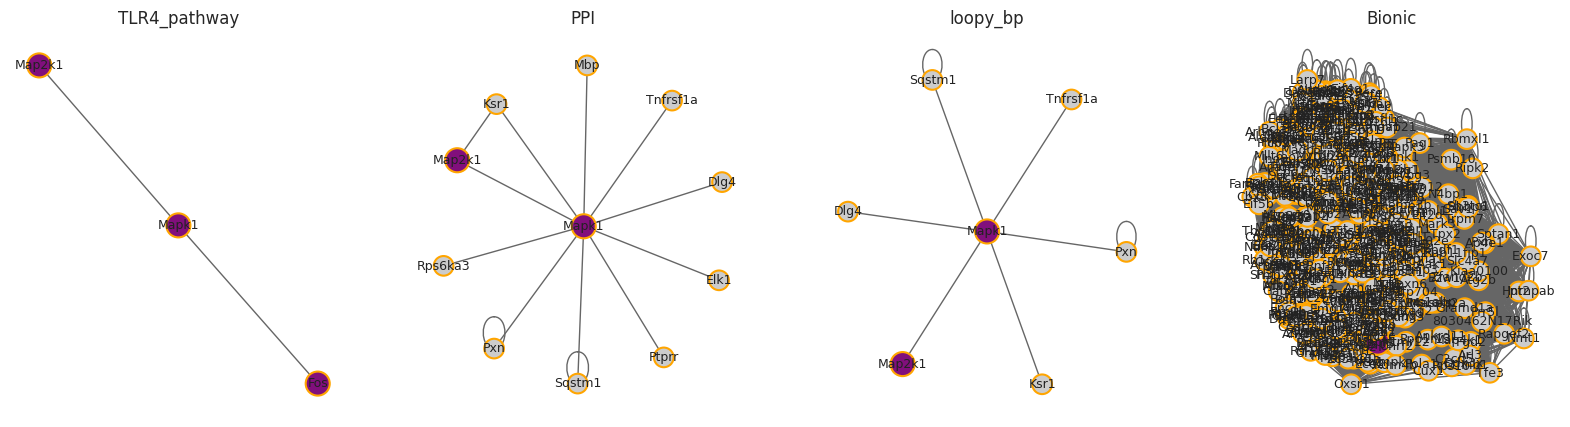

In [92]:
# Set up visualization style
sns.set({"figure.facecolor": "white"})
sns.set_style("white")

# Clear the previous plot
plt.clf()

# Create subplots for each subnet
fig, axes = plt.subplots(1, len(subnets), figsize=(5 * len(subnets), 5))

# Ensure axes is iterable if there's only one subnet
if len(subnets) == 1:
    axes = [axes]

# Iterate over subnets and plot each one
for name, subnet, ax in zip(["TLR4_pathway", "PPI", "loopy_bp", "Bionic"], subnets, axes):
    # Determine node colors and sizes
    node_colors = []
    node_sizes = []
    for node in subnet.nodes():
        if node in moi:  # Check if the node is in the "moi" list or set
            node_colors.append("#810f7c")  # Highlight nodes of interest
            node_sizes.append(300)        # Larger size for nodes of interest
        else:
            node_colors.append("#cccccc")  # Default color
            node_sizes.append(200)         # Default size

    # Create node labels (label all nodes)
    labels = {node: node for node in subnet.nodes()}

    # Plot the network
    nx.draw_networkx(
        subnet,
        pos=nx.spring_layout(subnet),
        ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        labels=labels,
        font_size=9,
        linewidths=1.5,  # Edge line width
        edgecolors="orange",  # Outline color for nodes
        edge_color="#666666",  # Edge color
        font_color="#222222",  # Font color
    )
    # Set title for the subnet
    ax.set_title(f"{name}")
    ax.axis("off")

# Show the plot
plt.show()
